Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

Actinic keratosis

Basal cell carcinoma

Dermatofibroma

Melanoma

Nevus

Pigmented benign keratosis

Seborrheic keratosis

Squamous cell carcinoma

Vascular lesion

In [1]:
# Import all the important libraries


import pathlib
import tensorflow as tf
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from __future__ import print_function
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.regularizers import l2  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Data Reading/Data Understanding:

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Test")
     
     

In [4]:
# distribution of test and train images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Dataset Creation**

In [5]:
#batch size
batch_size = 32
img_height = 180
img_width = 180

Create train & validation dataset from the train directory

In [6]:

## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  validation_split=0.2,
  color_mode='rgb',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
#test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  labels='inferred',
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Dataset visualisation 

Create a code to visualize one instance of all the nine classes present in the dataset 

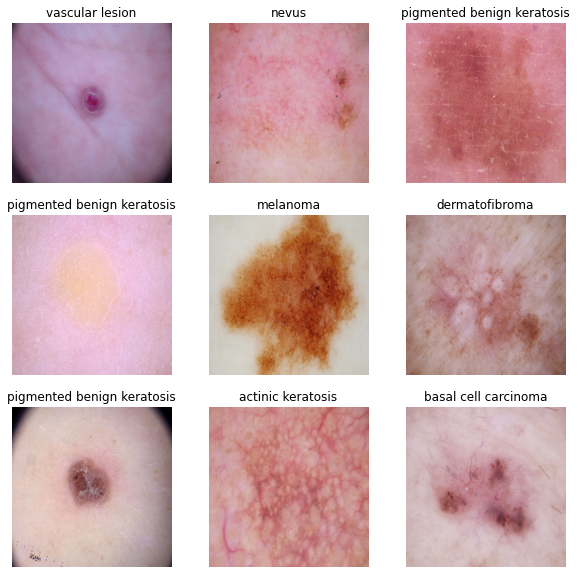

In [10]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (3 referes to channel  RGB).


 The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
     

**Create the Model**

rescale images to normalize pixel values between (0,1).

In [12]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]


**Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. **

Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). 

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

### CNN Model 


In [13]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Adding Conv layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 45, 45, 64)       0         
 pper)                                                  

Compile the model

In [14]:

### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.optimizers import Adam
optimizer_1 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function_1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer_1,
              loss=loss_function_1,
              metrics=['accuracy'])
     

In [15]:

# View the summary of all layers
model.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 45, 45, 64)       0         
 pper)                                                  

In [16]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)
     

In [17]:
epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=[learning_rate_reduction]
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 216s 860ms/step - loss: 1.9817 - accuracy: 0.2528 - val_loss: 2.0095 - val_accuracy: 0.2394 - lr: 0.0010


The model accuracies are:

train -- 25.28%

val -- 23.94

Which is a very poor model with a high underfitting

**Create model with  dropout to address the overfitting**

Dropout and L2 regularization are used as augmentation to prevent the overfitting

In [18]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Adding Conv layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_12 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_13 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 90, 90, 64)       18496     
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 45, 45, 64)       0         
 apper)                                               

In [19]:
### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.optimizers import Adam
optimizer_1 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function_1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer_1,
              loss=loss_function_1,
              metrics=['accuracy'])
     

In [20]:
# View the summary of all layers
model.summary()
     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_12 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_13 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 90, 90, 64)       18496     
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 45, 45, 64)       0         
 apper)                                               

In [21]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

Train the model for ~20 epoch

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,callbacks=[learning_rate_reduction]
)

Epoch 1/20
56/56 [==============================] - 5s 65ms/step - loss: 2.0241 - accuracy: 0.2260 - val_loss: 1.8685 - val_accuracy: 0.3289 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8360 - accuracy: 0.3136 - val_loss: 1.7755 - val_accuracy: 0.3535 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6584 - accuracy: 0.3990 - val_loss: 1.5267 - val_accuracy: 0.4676 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5020 - accuracy: 0.4743 - val_loss: 1.4814 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4813 - accuracy: 0.4771 - val_loss: 1.4404 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3923 - accuracy: 0.5095 - val_loss: 1.4558 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3

both training and validation accuracies are increased but still not good enough and it shows overfitting


 accuracy: 0.7355 - val_loss: 1.5912 - val_accuracy: 0.5548 - lr: 2.5000e-04

## Visualize the training Results

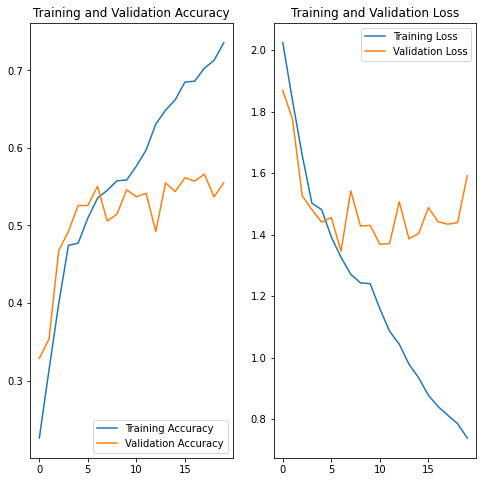

In [23]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

In [24]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 19ms/step - loss: 1.5912 - accuracy: 0.5548
Accuracy:  0.7661830186843872
Validation Accuracy:  0.5548098683357239
Loss:  0.6338330507278442
Validation Loss 1.5911773443222046


Model 1: Insights:

1. With the increase in the number of epochs training accuracy increased
  Final accuracy for training dataset is 76.6%
2. Validation accuracy is 55.48%
3.Training loss is .63
4. Validation loss is 1.52

We can see that validation dataset accuracy is significantly lower than training dataset accuracy, it is the sign of overfitting
Overfitting happened since we have less number of training images and model has learnt from noise or unwanted details around the training data.

To address this issue we can use Data Augmentation to overcome overfitting. 

Data augmentation will add additional training data by applying transformation on existing data. This will expose the model to more aspects of the data.





**Model - 2: Model Building & training on the augmented data :**

CNN Model with Augment strategy and Dropout layer

In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
      [
       # Random flip of image of horizontal axis
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
       # Random rotation of image
        layers.experimental.preprocessing.RandomRotation(0.2),
       # Random zoom of image
        layers.experimental.preprocessing.RandomZoom(0.2),
      ]
    )

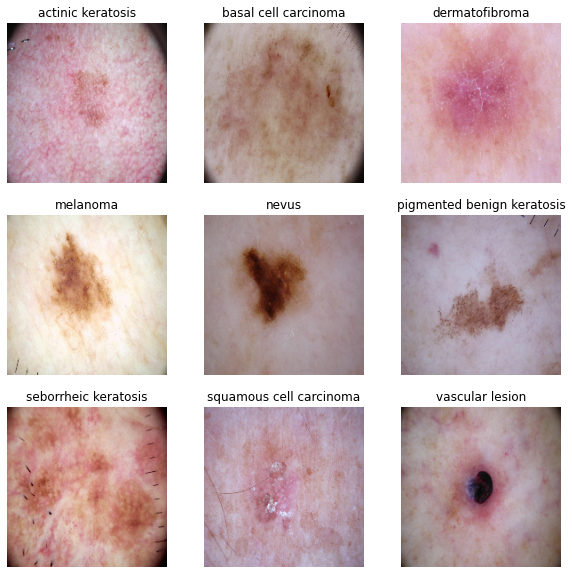

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
fig = plt.figure(figsize=(10, 10))

classes = range(len(class_names))
for images, labels in val_ds.take(2):
    missing = []
    for i in classes:
        ax = fig.add_subplot(3, 3, 1 + i)
        x = np.where(labels[:]==i)[0]
        if len(x) > 0:
            idx = np.where(labels[:]==i)[0][0]
            augmented_images = data_augmentation(images)
            im = images[idx].numpy().astype("uint8")
            plt.imshow(im)
            plt.title(class_names[labels[idx]])
            plt.axis("off")
        else:
            missing.append(i) # Appending list for missing classes
    if len(missing) > 0:
        classes = missing
        continue
    else:
        break
     

To do Create the model, compile and train the model

In [27]:

## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Adding Conv layers
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_25 (ModuleWr  (None, 180, 180, 16)     448       
 apper)                                                          
                                                                 
 module_wrapper_26 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_27 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                                          
                                                                 
 module_wrapper_28 (ModuleWr  (None, 45, 45, 32)       0         
 apper)                                               

Compile the model

In [28]:

## Your code goes here
#Choose an appropriate optimiser and loss function for model training
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

Training the model

In [29]:

## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/20
56/56 [==============================] - 3s 32ms/step - loss: 2.0289 - accuracy: 0.2148 - val_loss: 1.8422 - val_accuracy: 0.3490 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.7938 - accuracy: 0.3376 - val_loss: 1.6914 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.7032 - accuracy: 0.3683 - val_loss: 1.6074 - val_accuracy: 0.4586 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.6076 - accuracy: 0.4291 - val_loss: 1.6709 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5644 - accuracy: 0.4314 - val_loss: 1.6185 - val_accuracy: 0.4564 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4635 - accuracy: 0.4916 - val_loss: 1.4247 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4

Visualizing the results

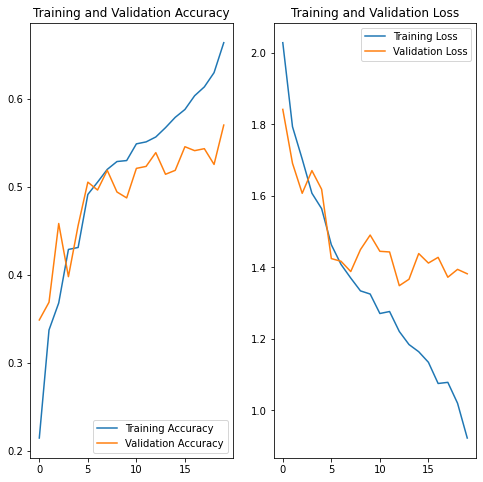

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

To do: Write your findings after the model fit, see if the earlier issue is resolved or not?

Model accuracies are:
 loss: 0.9225 - accuracy: 0.6641 - val_loss: 1.3822 - val_accuracy: 0.5705 - lr: 5.0000e-04

which shows the model is quite better in terms of address the overfitting but overall model accuaracies are significantly low.. 

It is not a good model as of now  it sowhs underfitting need to improve the accuracies

In [31]:

## Your code goes here.

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 12ms/step - loss: 1.3822 - accuracy: 0.5705
Accuracy:  0.7114955186843872
Validation Accuracy:  0.5704697966575623
Loss:  0.7949563264846802
Validation Loss 1.3821607828140259




*   both training and validation accuracies got increased due to increase in epochs.
*   Training accuracies and validation accuracies are increased.

*   Model is underfitting -- validation accuracy is decreased to  57% from 71%
*   still need to improve the model






In [32]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]     
path_list 

['/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0025223.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0026417.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0026254.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0027008.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0027044.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0026313.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cance

In [33]:

lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list
     

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

Another reason of low performance of model could be the immbalance data:

Lets check that:

In [35]:
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

There is clear sign of class imbalance in the dataset:
1. seborrheic keratosis and dermatofibroma are having least images.
2. pigmented benign keratosis and melanoma are more 
3. Need to address the class imbalance to address underfitting

**Handling class imbalances:** 

Rectify class imbalances present in the training dataset with Augmentor library.

In [36]:

!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:

path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## 500 samples are added to all the categories of images to make it more uniform.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9BF88994C0>: 100%|██████████| 500/500 [00:23<00:00, 21.30 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9C0C11C1F0>: 100%|██████████| 500/500 [00:22<00:00, 22.31 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9C0C4E6940>: 100%|██████████| 500/500 [00:22<00:00, 22.05 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9C0C12E430>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9C0C0F5EB0>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9BF891FCA0>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9C0C3C7430>: 100%|██████████| 500/500 [00:42<00:00, 11.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9BF8EECA00>: 100%|██████████| 500/500 [00:18<00:00, 27.51 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9C750EA880>: 100%|██████████| 500/500 [00:17<00:00, 28.23 Samples/s]


In [38]:
# Total count of augmented image


image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Distribution of augmented data after adding new images to the original training data

In [39]:

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033675.jpg_95839125-506d-4b17-9324-8266f281f459.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029039.jpg_f263acbc-881c-466d-825e-3b3b599f7850.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029177.jpg_bb069e78-66bb-4513-8431-1666bc4d51f4.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027613.jpg_94ca536b-d5e5-41ac-afa3-a16fe5ae9c23.jpg',
 '/content/gdrive/MyDrive/CNN_Melanoma_Detection_sukh/Skin cancer ISIC The International

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [41]:

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
     

In [43]:
#value counts after augmentation

new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

The number of images in each categories are more now which would solve the problem

Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

Train data

In [45]:

#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Validation data set creation

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)
     

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Todo: Create your model (make sure to include normalization)

Model 3: CNN Model with Augmentor to rectify imbalance class data

In [47]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# Adding Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_40 (ModuleWr  (None, 180, 180, 16)     448       
 apper)                                                          
                                                                 
 module_wrapper_41 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_42 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                                          
                                                                 
 module_wrapper_43 (ModuleWr  (None, 45, 45, 32)       0         
 apper)                                               

Todo: Compile your model (Choose optimizer and loss function appropriately)

In [48]:
### choosing an appropirate optimiser and loss function
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])
     

Train the model for 20 epochs

In [49]:

epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learning_rate_reduction]
)

Epoch 1/30
169/169 [==============================] - 32s 183ms/step - loss: 1.9636 - accuracy: 0.2339 - val_loss: 1.5623 - val_accuracy: 0.4083 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 33s 188ms/step - loss: 1.5395 - accuracy: 0.3993 - val_loss: 1.3560 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 32s 185ms/step - loss: 1.3891 - accuracy: 0.4607 - val_loss: 1.3132 - val_accuracy: 0.4618 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 31s 180ms/step - loss: 1.2702 - accuracy: 0.5078 - val_loss: 1.2117 - val_accuracy: 0.5241 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 31s 180ms/step - loss: 1.1142 - accuracy: 0.5603 - val_loss: 1.1264 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 31s 179ms/step - loss: 0.9929 - accuracy: 0.6122 - val_loss: 1.1317 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

In [50]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)
     

43/43 [==============================] - 6s 113ms/step - loss: 0.5643 - accuracy: 0.8716
Accuracy:  0.9603115916252136
Validation Accuracy:  0.8715664148330688
Loss:  0.09742846339941025
Validation Loss 0.5643184781074524


To do: Visualize the model results

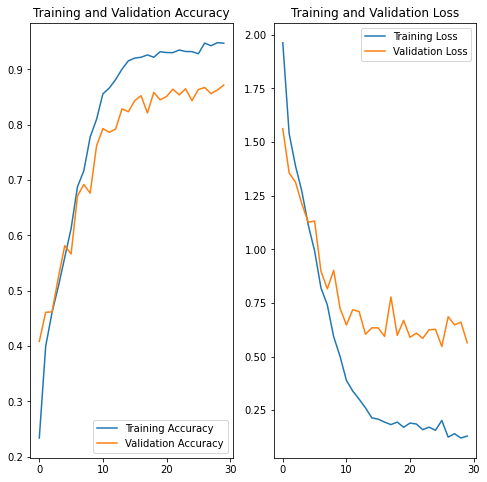

In [51]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Insight of Final Model**

Training accuracy is 95.51% and validation accuracy is 87.3 %

After using Augmentor and using imbalance of all classes, significance improvement in the training and validation accuracy are observed.

More epochs can be added to increase the accuracy Further but too much epoch would cause overfitting too.  so epoch =30 is quite great enough

 Overfitting or underfitting issues are resloved in the final model

 Training and validation loss has been decreased due to increase in epoch